# Structure and Surprise in Lana Del Rey’s Lyrics and Poetry

This notebook analyzes song lyrics and poetry using lexical, structural,
and phonetic features. We compare albums across a structure–surprise
space and examine how sound-based structure operates differently in poetry.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/features/song_features.csv")
df.head()



,repetition_rate,third_person_rate,first_person_rate,lexical_entropy,album,song,second_person_rate,line_end_similarity
0,0.7045,0.000,183.673,4.4643,aka_lizzy_grant,aka_lizzy_grant_brite_lites.txt,20.408,0.8409
1,0.2000,0.000,93.333,5.8875,aka_lizzy_grant,aka_lizzy_grant_for_K_part_2.txt,120.000,0.4500
2,0.5167,0.000,106.132,5.6428,aka_lizzy_grant,aka_lizzy_grant_gramma.txt,28.302,0.6333
3,0.4571,9.901,24.752,5.0361,aka_lizzy_grant,aka_lizzy_grant_jump.txt,133.663,0.5143
4,0.5714,4.630,134.259,5.0833,aka_lizzy_grant,aka_lizzy_grant_kill_kill.txt,32.407,0.6286


In [2]:
df.columns

Index(['repetition_rate', 'third_person_rate', 'first_person_rate',
       'lexical_entropy', 'album', 'song', 'second_person_rate',
       'line_end_similarity'],
      dtype='object')

In [15]:
import pandas as pd

# 1) Load the features table (adjust path if needed)
df = pd.read_csv("../data/features/song_features.csv")

# 2) Define which "albums" are actually poetry collections
POETRY_ALBUMS = {
    "ariel",
    "violet_bent_backwards_over_the_grass",
}

# 3) Ensure a text_type column exists (no KeyError ever again)
df["text_type"] = df["album"].apply(lambda a: "poem" if a in POETRY_ALBUMS else "song")

# 4) Clean splits you can reuse everywhere
df_songs = df[df["text_type"] == "song"].copy()
df_poems = df[df["text_type"] == "poem"].copy()

# 5) Quick sanity checks (so you can trust it)
print(df["text_type"].value_counts())
print("Song albums:", sorted(df_songs["album"].unique()))
print("Poetry collections:", sorted(df_poems["album"].unique()))


text_type
song    71
poem    29
Name: count, dtype: int64
Song albums: ['aka_lizzy_grant', 'born_to_die', 'lust_for_life', 'nfr', 'ultraviolence']
Poetry collections: ['ariel', 'violet_bent_backwards_over_the_grass']


## Song Albums: Structure vs. Surprise

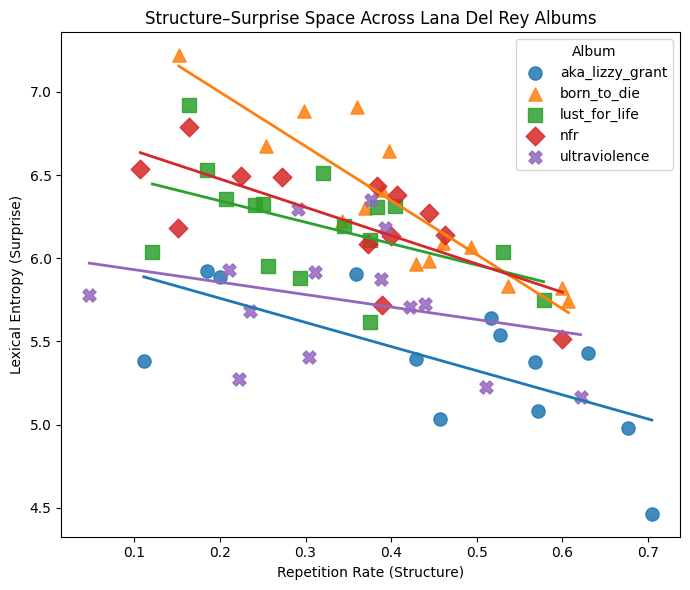

In [17]:

plt.figure(figsize=(7, 6))

albums = df_songs["album"].unique()

markers = {
    "aka_lizzy_grant": "o",
    "born_to_die": "^",
    "ultraviolence": "X",
    "lust_for_life": "s",
    "nfr": "D",
    
}

for album in albums:
    sub = df_songs[df_songs["album"] == album]

    # Scatter
    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=90,
        alpha=0.85,
        marker=markers.get(album, "o"),
        label=album
    )

    # Regression line
    x = sub["repetition_rate"].values
    y = sub["lexical_entropy"].values

    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m * xs + b, linewidth=2)

plt.xlabel("Repetition Rate (Structure)")
plt.ylabel("Lexical Entropy (Surprise)")
plt.title("Structure–Surprise Space Across Lana Del Rey Albums")
plt.legend(title="Album")
plt.tight_layout()
plt.show()


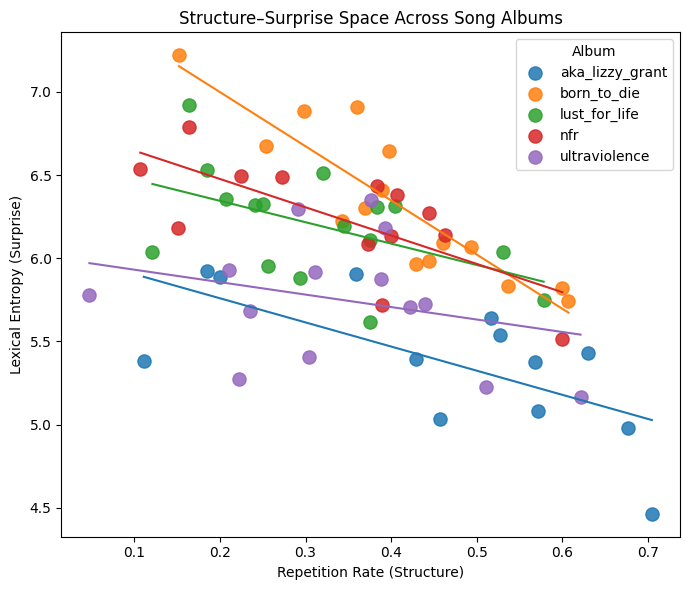

In [18]:
plt.figure(figsize=(7, 6))

albums = df_songs["album"].unique()

for album in albums:
    sub = df_songs[df_songs["album"] == album]
    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=90,
        alpha=0.85,
        label=album
    )

    if len(sub) > 1:
        x = sub["repetition_rate"].values
        y = sub["lexical_entropy"].values
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, m * xs + b)

plt.xlabel("Repetition Rate (Structure)")
plt.ylabel("Lexical Entropy (Surprise)")
plt.title("Structure–Surprise Space Across Song Albums")
plt.legend(title="Album")
plt.tight_layout()
plt.show()


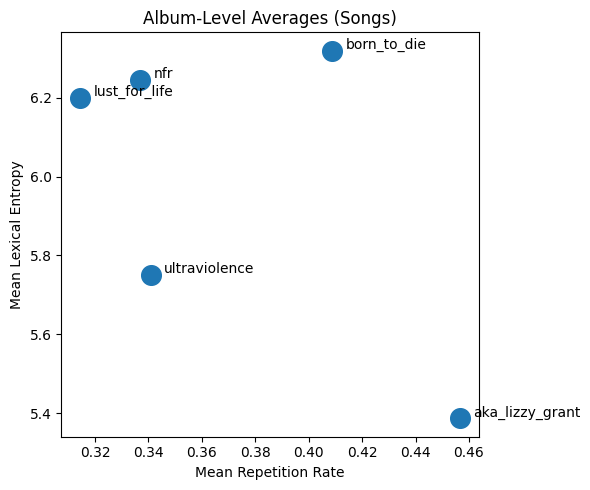

In [19]:
song_means = (
    df_songs
    .groupby("album")[["repetition_rate", "lexical_entropy"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 5))
plt.scatter(
    song_means["repetition_rate"],
    song_means["lexical_entropy"],
    s=200
)

for _, row in song_means.iterrows():
    plt.text(
        row["repetition_rate"] + 0.005,
        row["lexical_entropy"] + 0.005,
        row["album"]
    )

plt.xlabel("Mean Repetition Rate")
plt.ylabel("Mean Lexical Entropy")
plt.title("Album-Level Averages (Songs)")
plt.tight_layout()
plt.show()


In [6]:
pip install pronouncing

Note: you may need to restart the kernel to use updated packages.


## Poetry: Phonetic Structure vs Surprise


In [22]:
import pronouncing
import re

def get_phonetic_ending(word):
    phones = pronouncing.phones_for_word(word.lower())
    if not phones:
        return None

    # Take first pronunciation
    phonemes = phones[0].split()

    # Get last stressed vowel onward
    for i in range(len(phonemes) - 1, -1, -1):
        if phonemes[i][-1].isdigit():  # stress marker
            return tuple(phonemes[i:])
    return tuple(phonemes[-2:])


In [23]:
def phonetic_endings(text):
    endings = []
    for line in text.split("\n"):
        words = re.findall(r"\b\w+\b", line)
        if words:
            pe = get_phonetic_ending(words[-1])
            if pe:
                endings.append(pe)
    return endings


In [27]:
from collections import Counter

def phonetic_repetition_rate(endings):
    if not endings:
        return 0
    counts = Counter(endings)
    repeats = sum(c - 1 for c in counts.values() if c > 1)
    return repeats / len(endings)


In [28]:
import math

def phonetic_entropy(endings):
    if not endings:
        return 0
    counts = Counter(endings)
    total = sum(counts.values())
    probs = [c / total for c in counts.values()]
    return -sum(p * math.log2(p) for p in probs)


In [29]:
plt.figure(figsize=(6, 5))

for collection in df_poems["album"].unique():
    sub = df_poems[df_poems["album"] == collection]
    plt.scatter(
        sub["phonetic_repetition_rate"],
        sub["phonetic_entropy"],
        s=90,
        alpha=0.85,
        label=collection
    )

plt.xlabel("Phonetic Repetition Rate")
plt.ylabel("Phonetic Entropy")
plt.title("Sound-Based Structure–Surprise in Poetry")
plt.legend(title="Collection")
plt.tight_layout()
plt.show()


KeyError: 'phonetic_repetition_rate'

<Figure size 600x500 with 0 Axes>

In [30]:
plt.figure(figsize=(6, 5))

for ttype, marker in [("song", "o"), ("poem", "X")]:
    sub = df[df["text_type"] == ttype]
    plt.scatter(
        sub["lexical_entropy"],
        sub["phonetic_entropy"],
        s=90,
        alpha=0.8,
        marker=marker,
        label=ttype
    )

plt.xlabel("Lexical Entropy (Word Surprise)")
plt.ylabel("Phonetic Entropy (Sound Surprise)")
plt.title("Lexical vs Phonetic Surprise Across Text Types")
plt.legend(title="Text Type")
plt.tight_layout()
plt.show()


KeyError: 'phonetic_entropy'

<Figure size 600x500 with 0 Axes>

In [ ]:
centroids = (
    df.groupby(["text_type", "album"])[
        ["phonetic_repetition_rate", "phonetic_entropy"]
    ]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 5))

for ttype, marker in [("song", "o"), ("poem", "X")]:
    sub = centroids[centroids["text_type"] == ttype]
    plt.scatter(
        sub["phonetic_repetition_rate"],
        sub["phonetic_entropy"],
        s=200,
        marker=marker,
        label=ttype
    )
    for _, row in sub.iterrows():
        plt.text(
            row["phonetic_repetition_rate"] + 0.005,
            row["phonetic_entropy"] + 0.005,
            row["album"],
            fontsize=9
        )

plt.xlabel("Mean Phonetic Repetition")
plt.ylabel("Mean Phonetic Entropy")
plt.title("Average Sound Structure Across Albums and Poetry")
plt.legend(title="Text Type")
plt.tight_layout()
plt.show()


Index(['repetition_rate', 'third_person_rate', 'first_person_rate',
       'lexical_entropy', 'album', 'song', 'second_person_rate',
       'line_end_similarity'],
      dtype='object')